In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#sys.path.insert(1, r'C:\Users\Ilyasov\Downloads\Python_prj\GitProjects\local_python_scripts\function_library'.replace('\\',"/"))
sys.path.insert(1, r'C:\Users\mendgaziev\Desktop\Git\local_python_scripts/medusa'.replace('\\',"/"))
sys.path.insert(1, r'C:\Users\mendgaziev\Desktop\Git\local_python_scripts/function_library'.replace('\\',"/"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pylab import rcParams

from statsmodels.tsa.arima.model import ARIMA

from db_operations import select_query_rzd_encode, select_query, DBlist, prognoz_insert_values, prognoz_execute_queries, prognoz_create_table

## Таблица oil_export_forecast

In [44]:
oil_export_forecast = select_query(f"""select date_in as date, volume, fact from oil_export_forecast 
                                       --where fact is true
                                       order by date_in""")
oil_export_forecast.date = pd.to_datetime(oil_export_forecast.date)

C:\Users\mendgaziev\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [45]:
def get_oil_export_forecast(df_fact, start_date, end_date, order):
    df = df_fact[df_fact.fact == True].copy()
    df = df[['date', 'volume']]
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    
    model = ARIMA(df, order=order)
    model_fit = model.fit()

    pred = model_fit.predict(start_date, end_date)
    pred = pd.DataFrame(pred).rename(columns={'predicted_mean': 'volume'}).reset_index()
    pred['index'] = pd.to_datetime(pred['index'])
    pred = pred.set_index('index')
    
    plt.figure(figsize = (10, 4))
    plt.plot(df, label = 'fact', color = "black")
    plt.plot(pred, label = 'forecast', color = "red")
    plt.legend()
    plt.grid()
    plt.show()
        
    return pred

C:\Users\mendgaziev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mendgaziev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mendgaziev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mendgaziev\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mendgaziev\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimizati

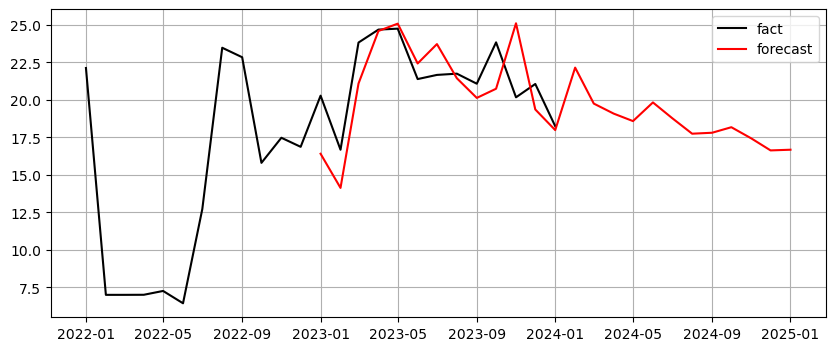

In [78]:
oil_exp_forecast = get_oil_export_forecast(oil_export_forecast, '2023-01-01', '2024-12-31', (5,2,3))

In [79]:
def save_DB_oil_export_forecast(df):   
    df_forecast = df.reset_index().rename(columns={'index':'date_in'})
    df_forecast['agg'] = 'M'
    df_forecast['fact'] = False
    df_forecast = df_forecast[df_forecast.date_in > oil_export_forecast[oil_export_forecast.fact == True].date.max()]
    
    if (df_forecast['date_in'].isin(oil_export_forecast.date)).any():
        print('Прогноз за эти даты уже есть в БД')
        
    else:
        engine = create_engine('postgresql+psycopg2://prognoz:prognoz@')
        print('Новые данные прогноза загружены в БД')
    
        return df_forecast.to_sql('oil_export_forecast', engine, if_exists='append', index=False)

In [80]:
save_DB_oil_export_forecast(oil_exp_forecast)

Новые данные прогноза загружены в БД


12

## Таблица oil_isolations_ktk

In [748]:
oil_isolations_ktk = select_query("select port_name,port_id,region,coridor,date,volume, fact from oil_isolations_ktk")
oil_isolations_ktk.date = pd.to_datetime(oil_isolations_ktk.date)
oil_isolations_ktk

,port_name,port_id,region,coridor,date,volume,fact
0,КТК,-1,Казахстан транзит,Черноморско-каспийский регион,2022-01-01,4885.869000,True
1,КТК,-1,Казахстан транзит,Черноморско-каспийский регион,2022-02-01,5053.585000,True
2,КТК,-1,Казахстан транзит,Черноморско-каспийский регион,2022-03-01,4517.821000,True
3,КТК,-1,Казахстан транзит,Черноморско-каспийский регион,2022-04-01,4609.302000,True
4,КТК,-1,Казахстан транзит,Черноморско-каспийский регион,2022-05-01,5168.878000,True
...,...,...,...,...,...,...,...
254,ПНХ Ю.Корчагин,1644,Республика Алтай,Черноморско-каспийский регион,2024-09-01,101.258229,False
255,ПНХ Ю.Корчагин,1644,Республика Алтай,Черноморско-каспийский регион,2024-10-01,101.807818,False
256,ПНХ Ю.Корчагин,1644,Республика Алтай,Черноморско-каспийский регион,2024-11-01,98.678452,False
257,ПНХ Ю.Корчагин,1644,Республика Алтай,Черноморско-каспийский регион,2024-12-01,98.722998,False


In [764]:
def get_oil_isolations_ktk(df_fact, idPort, start_date, end_date, order):
    df = df_fact[(df_fact.fact == True) & (df_fact.port_id == idPort)].copy()
    df = df[['date', 'volume']]
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    
    model = ARIMA(df, order=order)
    model_fit = model.fit()

    pred = model_fit.predict(start_date, end_date)
    pred = pd.DataFrame(pred).rename(columns={'predicted_mean': 'volume'}).reset_index()
    pred['index'] = pd.to_datetime(pred['index'])
    pred = pred.set_index('index')
    
    plt.figure(figsize = (10, 4))
    plt.plot(df, label = 'fact', color = "black")
    plt.plot(pred, label = 'forecast', color = "red")
    plt.legend()
    plt.grid()
    plt.show()
        
    return pred

In [765]:
def save_DB_oil_isolations_ktk(df, idPort):   
    df_forecast = df.reset_index().rename(columns={'index':'date_in'})
    df_forecast['fact'] = False
    df_forecast['port_id'] = idPort
    df_forecast = df_forecast.merge(oil_isolations_ktk[['port_name', 'port_id', 'region', 'coridor']],
                                   on = 'port_id', how='left').drop_duplicates()
    df_forecast = df_forecast[df_forecast.date_in > oil_isolations_ktk[oil_isolations_ktk.fact == True].date.max()]
    print(df_forecast)   
    
    if (df_forecast['date_in'].isin(oil_isolations_ktk.date)).any():
        print()
        print('Прогноз за эти даты уже есть в БД')
        
    else:
        engine = create_engine('postgresql+psycopg2://prognoz:prognoz@')
        print()
        print('Новые данные прогноза загружены в БД')
    
        return df_forecast.to_sql('oil_isolations_ktk', engine, if_exists='append', index=False)

#### KTK

In [766]:
port_id = -1

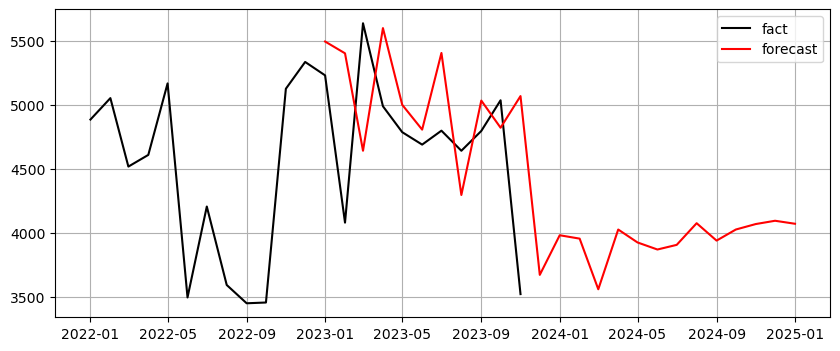

In [767]:
ktk_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (4,2,3))

In [768]:
save_DB_oil_isolations_ktk(ktk_oil, port_id)

       date_in       volume   fact  port_id port_name             region  \
407 2023-12-01  3670.606924  False       -1       КТК  Казахстан транзит   
444 2024-01-01  3980.658289  False       -1       КТК  Казахстан транзит   
481 2024-02-01  3954.204441  False       -1       КТК  Казахстан транзит   
518 2024-03-01  3557.944745  False       -1       КТК  Казахстан транзит   
555 2024-04-01  4025.462215  False       -1       КТК  Казахстан транзит   
592 2024-05-01  3924.341179  False       -1       КТК  Казахстан транзит   
629 2024-06-01  3869.037770  False       -1       КТК  Казахстан транзит   
666 2024-07-01  3905.422525  False       -1       КТК  Казахстан транзит   
703 2024-08-01  4074.791108  False       -1       КТК  Казахстан транзит   
740 2024-09-01  3938.802969  False       -1       КТК  Казахстан транзит   
777 2024-10-01  4025.509709  False       -1       КТК  Казахстан транзит   
814 2024-11-01  4068.330639  False       -1       КТК  Казахстан транзит   
851 2024-12-

#### Де-Кастри

In [769]:
port_id = 154

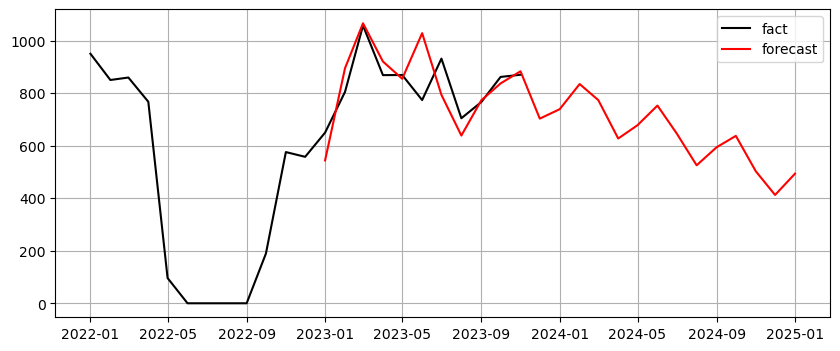

In [770]:
deCastri_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (4,2,3))

In [771]:
save_DB_oil_isolations_ktk(deCastri_oil, port_id)

       date_in      volume   fact  port_id    port_name            region  \
407 2023-12-01  703.343526  False      154  п.Де-Кастри  Хабаровский край   
444 2024-01-01  739.274769  False      154  п.Де-Кастри  Хабаровский край   
481 2024-02-01  835.059168  False      154  п.Де-Кастри  Хабаровский край   
518 2024-03-01  773.879491  False      154  п.Де-Кастри  Хабаровский край   
555 2024-04-01  627.559522  False      154  п.Де-Кастри  Хабаровский край   
592 2024-05-01  678.242797  False      154  п.Де-Кастри  Хабаровский край   
629 2024-06-01  753.031142  False      154  п.Де-Кастри  Хабаровский край   
666 2024-07-01  646.831572  False      154  п.Де-Кастри  Хабаровский край   
703 2024-08-01  525.606158  False      154  п.Де-Кастри  Хабаровский край   
740 2024-09-01  594.135428  False      154  п.Де-Кастри  Хабаровский край   
777 2024-10-01  637.606202  False      154  п.Де-Кастри  Хабаровский край   
814 2024-11-01  502.929294  False      154  п.Де-Кастри  Хабаровский край   

#### Пригородное

In [772]:
port_id = 158

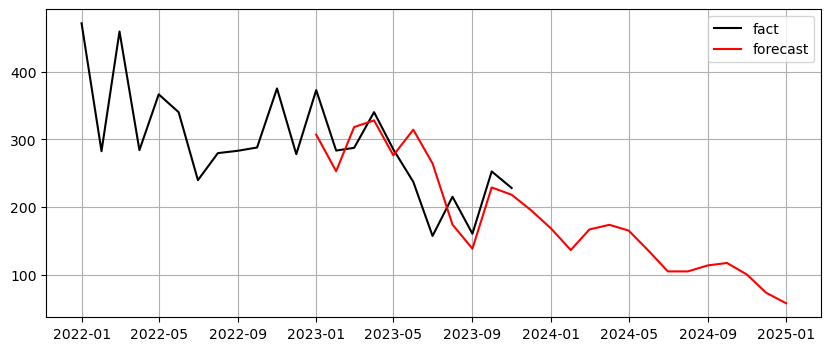

In [773]:
prigorod_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (4,2,3))

In [774]:
save_DB_oil_isolations_ktk(prigorod_oil, port_id)

       date_in      volume   fact  port_id      port_name  \
407 2023-12-01  195.618009  False      158  п.Пригородное   
444 2024-01-01  168.849915  False      158  п.Пригородное   
481 2024-02-01  136.790558  False      158  п.Пригородное   
518 2024-03-01  167.103181  False      158  п.Пригородное   
555 2024-04-01  173.950566  False      158  п.Пригородное   
592 2024-05-01  165.521181  False      158  п.Пригородное   
629 2024-06-01  135.643888  False      158  п.Пригородное   
666 2024-07-01  105.244219  False      158  п.Пригородное   
703 2024-08-01  105.191394  False      158  п.Пригородное   
740 2024-09-01  114.029375  False      158  п.Пригородное   
777 2024-10-01  117.662141  False      158  п.Пригородное   
814 2024-11-01  100.616299  False      158  п.Пригородное   
851 2024-12-01   73.636086  False      158  п.Пригородное   
888 2025-01-01   58.198505  False      158  п.Пригородное   

                  region               coridor  
407  Сахалинская область  Тихоокеан

#### Варандей

In [776]:
port_id = 160

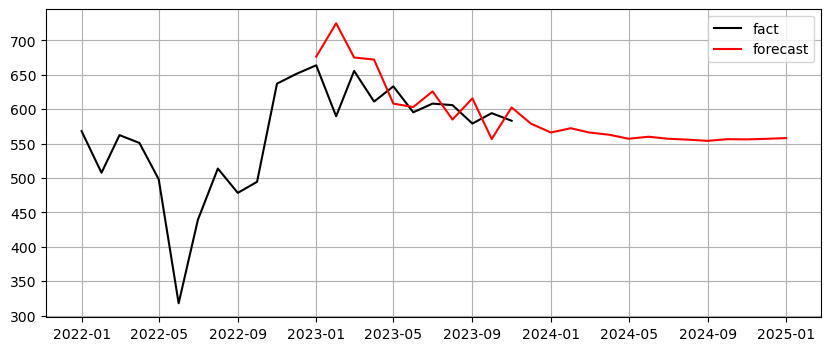

In [777]:
varand_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (3,3,1))

In [778]:
save_DB_oil_isolations_ktk(varand_oil, port_id)

       date_in      volume   fact  port_id   port_name  \
407 2023-12-01  579.110337  False      160  п.Варандей   
444 2024-01-01  566.203601  False      160  п.Варандей   
481 2024-02-01  572.411002  False      160  п.Варандей   
518 2024-03-01  566.155776  False      160  п.Варандей   
555 2024-04-01  562.951276  False      160  п.Варандей   
592 2024-05-01  557.101754  False      160  п.Варандей   
629 2024-06-01  560.040508  False      160  п.Варандей   
666 2024-07-01  557.135102  False      160  п.Варандей   
703 2024-08-01  555.803487  False      160  п.Варандей   
740 2024-09-01  554.056328  False      160  п.Варандей   
777 2024-10-01  556.449213  False      160  п.Варандей   
814 2024-11-01  556.226130  False      160  п.Варандей   
851 2024-12-01  556.991125  False      160  п.Варандей   
888 2025-01-01  558.086240  False      160  п.Варандей   

                        region             coridor  
407  Ненецкий автономный округ  Арктический регион  
444  Ненецкий автономны

#### Сабетта

In [781]:
port_id = 850

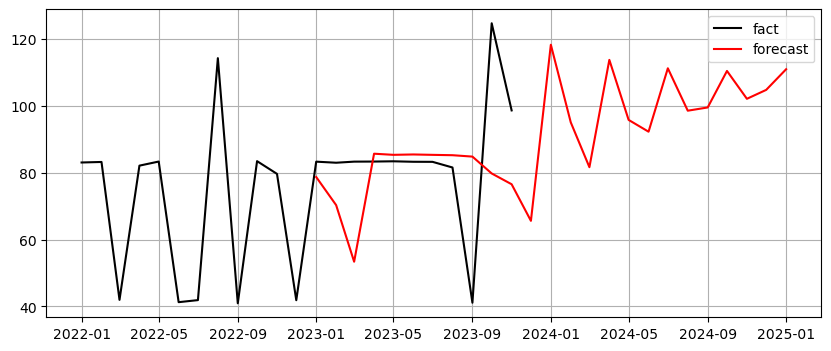

In [782]:
sabetta_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (2,2,1))

In [783]:
save_DB_oil_isolations_ktk(sabetta_oil, port_id)

       date_in      volume   fact  port_id  port_name  \
407 2023-12-01   65.632383  False      850  п.Сабетта   
444 2024-01-01  118.334985  False      850  п.Сабетта   
481 2024-02-01   95.098511  False      850  п.Сабетта   
518 2024-03-01   81.688207  False      850  п.Сабетта   
555 2024-04-01  113.800808  False      850  п.Сабетта   
592 2024-05-01   95.836860  False      850  п.Сабетта   
629 2024-06-01   92.306673  False      850  п.Сабетта   
666 2024-07-01  111.284951  False      850  п.Сабетта   
703 2024-08-01   98.593253  False      850  п.Сабетта   
740 2024-09-01   99.563061  False      850  п.Сабетта   
777 2024-10-01  110.487455  False      850  п.Сабетта   
814 2024-11-01  102.153307  False      850  п.Сабетта   
851 2024-12-01  104.820529  False      850  п.Сабетта   
888 2025-01-01  110.997498  False      850  п.Сабетта   

                              region             coridor  
407  Ямало-Ненецкий автономный округ  Арктический регион  
444  Ямало-Ненецкий автоно

#### Приразломная

In [784]:
port_id = 995

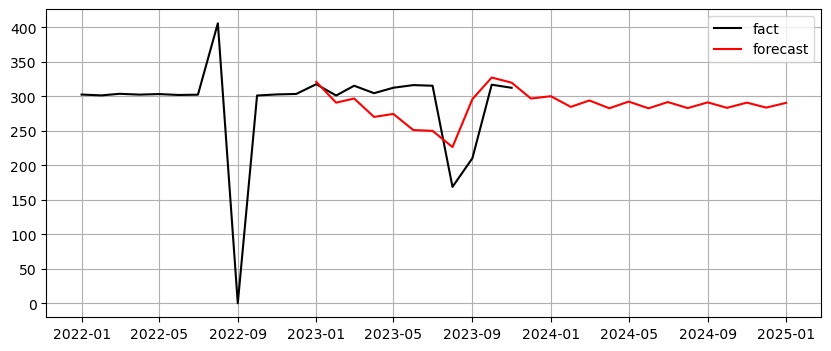

In [785]:
prirazlomn_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (2,0,2))

In [786]:
save_DB_oil_isolations_ktk(prirazlomn_oil, port_id)

       date_in      volume   fact  port_id        port_name  \
407 2023-12-01  296.712608  False      995  пл.Приразломная   
444 2024-01-01  300.108631  False      995  пл.Приразломная   
481 2024-02-01  284.657134  False      995  пл.Приразломная   
518 2024-03-01  293.918179  False      995  пл.Приразломная   
555 2024-04-01  282.623640  False      995  пл.Приразломная   
592 2024-05-01  292.295313  False      995  пл.Приразломная   
629 2024-06-01  282.573018  False      995  пл.Приразломная   
666 2024-07-01  291.626092  False      995  пл.Приразломная   
703 2024-08-01  282.889479  False      995  пл.Приразломная   
740 2024-09-01  291.179682  False      995  пл.Приразломная   
777 2024-10-01  283.250521  False      995  пл.Приразломная   
814 2024-11-01  290.806138  False      995  пл.Приразломная   
851 2024-12-01  283.593833  False      995  пл.Приразломная   
888 2025-01-01  290.472749  False      995  пл.Приразломная   

                        region             coridor  
4

#### ПНХ Ю.Корчагин

In [787]:
port_id = 1644

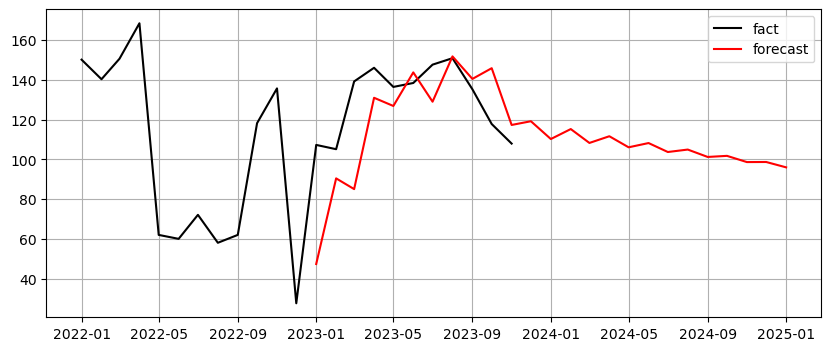

In [788]:
korchagin_oil = get_oil_isolations_ktk(oil_isolations_ktk, port_id, '2023-01-01', '2024-12-31', (2,2,3))

In [789]:
save_DB_oil_isolations_ktk(korchagin_oil, port_id)

       date_in      volume   fact  port_id       port_name            region  \
407 2023-12-01  119.208084  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
444 2024-01-01  110.266249  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
481 2024-02-01  115.277538  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
518 2024-03-01  108.299640  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
555 2024-04-01  111.664387  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
592 2024-05-01  106.106324  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
629 2024-06-01  108.246159  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
666 2024-07-01  103.744854  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
703 2024-08-01  104.973001  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
740 2024-09-01  101.258229  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
777 2024-10-01  101.807818  False     1644  ПНХ Ю.Корчагин  Республика Алтай   
814 2024-11-01   98.678452  False     16